# Trending YouTube Videos

In [138]:
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import json
import warnings
from IPython.lib.display import YouTubeVideo
import re
from IPython.core.display import display, HTML
pd.set_option('display.max_colwidth', -1) #for all data of df to be seen
import matplotlib.pyplot as plt
import matplotlib as mtpl
import math


In [3]:
HTML('''<script> code_shown=true;function code_toggle() {if (code_shown){$('div.input').hide();$('#toggleButton').val('Show Code')} else {$('div.input').show();$('#toggleButton').val('Hide Code')}code_shown = !code_shown}$( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" id="toggleButton"></form>''')

<img src="https://cdn.vox-cdn.com/thumbor/SfyqZw6l_jidAYdkqYEis-Omdho=/0x0:1680x1050/1200x675/filters:focal(706x391:974x659):no_upscale()/cdn.vox-cdn.com/uploads/chorus_image/image/56414327/YTLogo_old_new_animation.0.gif" width="600" height="240" align="center"/>

YouTube is an American video-sharing website headquartered in San Bruno, California. The service was created by three former PayPal employees—Chad Hurley, Steve Chen, and Jawed Karim—in February 2005. Google bought the site in November 2006 for US$1.65 billion; YouTube now operates as one of Google's subsidiaries.
YouTube allows users to upload, view, rate, share, add to favourites, report, comment on videos, and subscribe to other users. It offers a wide variety of user-generated and corporate media videos. Available content includes video clips, TV show clips, music videos, short and documentary films, audio recordings, movie trailers, live streams, and other content such as video blogging, short original videos, and educational videos. Most of the content on YouTube is uploaded by individuals, but media corporations including CBS, the BBC, Vevo, and Hulu offer some of their material via YouTube as part of the YouTube partnership program. Unregistered users can only watch videos on the site, while registered users are permitted to upload an unlimited number of videos and add comments to videos. 



## Trending Videos



Although the most viewed videos were initially viral videos the most viewed videos were increasingly related to music videos. In fact, since recently every video that has reached the top of the "most viewed YouTube videos" list has been a music video. Although the most viewed videos are no longer listed on the site, reaching the top of the list is still considered a tremendous feat.
YouTube maintains a list of the top trending videos on the platform. According to Variety magazine, “To determine the year’s top-trending videos, YouTube uses a combination of factors including measuring users interactions (number of views, shares, comments and likes). Note that they’re not the most-viewed videos overall for the calendar year”. Top performers on the YouTube trending list are music videos (such as the famously virile “Gangam Style”), celebrity and/or reality TV performances, and the random dude-with-a-camera viral videos that YouTube is well-known for.



## The Datasets



2 datasets will be used for the purpose of this project, 2 sets of five files csv and JSON

One of the datasets used is a daily record of the top trending YouTube videos. The dataset includes several months (and counting) of data on daily trending YouTube videos. Data is included for the US, GB, DE, CA, and FR regions (USA, Great Britain, Germany, Canada, and France, respectively), with up to 200 listed trending videos per day.
Each region’s data is in a separate file. Data includes the video title, channel title, publish time, tags, views, likes and dislikes, description, and comment count.

The second data set (JSON files) includes a category_id field and varies between regions. One such file is included for each of the five regions in the dataset.
.
The headers in the video files are:

•	video_id (Common id field to both comment and video csv files)

•	title

•	channel_title

•	category_id (Can be looked up using the included JSON files, but varies per region so use the appropriate JSON file for the CSV file's country)

•	tags (Separated by | character, [none] is displayed if there are no tags)

•	views

•	likes

•	dislikes

•	thumbnail_link

•	date (Formatted like so: [day].[month])


The headers in the comments file are:

•	video_id (Common id field to both comment and video csv files)

•	comment_text

•	likes

•	replies




## Data manipulation prosses 

In [4]:
# Upload Data
US_videos = pd.read_csv('USvideos.csv.zip')
US_videos_categories = pd.read_json('US_category_id.json')
CA_videos = pd.read_csv('CAvideos.csv.zip')
CA_videos_categories = pd.read_json('CA_category_id.json')
GB_videos = pd.read_csv('GBvideos.csv.zip')
GB_videos_categories = pd.read_json('GB_category_id.json')
FR_videos = pd.read_csv('FRvideos.csv.zip')
FR_videos_categories = pd.read_json('FR_category_id.json')
DE_videos = pd.read_csv('DEvideos.csv.zip')
DE_videos_categories = pd.read_json('DE_category_id.json')

In [5]:
#Create the video df
#df_videos = pd.concat([US_videos, CA_videos, GB_videos, FR_videos, DE_videos])
videos_list = [US_videos, CA_videos, GB_videos, FR_videos, DE_videos]
videos_all = pd.concat(videos_list, keys=['US', 'CA', 'GB', 'FR', 'DE'], names=['Country', 'Row ID'])

In [6]:
#Create the video categories df¶
#df_videos_categ = pd.concat([US_videos_categories, CA_videos_categories, GB_videos_categories,  FR_videos_categories, DE_videos_categories])
US_videos_categories['country'] = 'US'
GB_videos_categories['country'] = 'GB'
CA_videos_categories['country'] = 'CA'
FR_videos_categories['country'] = 'FR'
DE_videos_categories['country'] = 'DE'

df_videos_categ = pd.concat([US_videos_categories, 
                             CA_videos_categories, 
                             GB_videos_categories,  
                             FR_videos_categories, 
                             DE_videos_categories], keys=['US', 'CA', 'GB', 'FR', 'DE'])

#### Merging the data-sets
To create the full dataset the region’s data where uploaded and merged in one data frame. The files with the category information were uploaded and merged into another data set. The category id and category name where stored in a data frame the elements of witch were dictionaries. The column instead of pandas series where iteritems. As a result there were problems to treat the data since there was not a typical pandas series.
Below you can have a look of the category table.

In [7]:
df_videos_categ.head(1)

,,etag,items,kind,country
US,0,"""m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJvJAAShlR6hM""","{'kind': 'youtube#videoCategory', 'etag': '""m2yskBQFythfE4irbTIeOgYYfBU/Xy1mB4_yLrHy_BmKmPBggty2mZQ""', 'id': '1', 'snippet': {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'title': 'Film & Animation', 'assignable': True}}",youtube#videoCategoryListResponse,US


After merging the two datasets the final data set craeted contains 142,000 rows and 30 columns 

#### Formatting
The dates columns were formatted to datetime. Also, the hour, day and month info was extracted. Also the views, comments, likes columns were changes to integers.

#### Data Cleaning
In order to make the nessesary change in format some rows had to be deleted since there was wrong information stored as date in some cases. 
Also after merging the two data frames non-available values were replaced with zeros.
Cases where there are 0 likes or comments and a lot of views i.e. the users has decided to disable those features have not been removed.

In [8]:
# df_videos=pd.merge(videos_all)
# df_videos_categ.reset_index(inplace=True)
# del df_videos_categ['index']

In [9]:
#df_videos_categ.info()

In [10]:
#df_videos_categ.iloc[1]

In [11]:
#type(df_videos_categ.items)

In [12]:
#df_videos_categ.items

In [13]:
#iteritems, 'function' object is not iterable, has to be trated as function 
for column_name, el in df_videos_categ.items():
    if column_name == 'items':
        category_df = json_normalize(el)[['id', 'snippet.title']]
category_df['country'] = list(df_videos_categ['country'])

In [14]:
#category_df['snippet.title'].unique()

In [15]:
#category_df[['snippet.title', 'id', 'country']].groupby(['snippet.title', 'id'])['country'].\
#count().reset_index().sort_values('id',ascending=True)

In [16]:
#category_df.head()

In [17]:
#category_df.info()

In [18]:
category_df['id']=category_df['id'].astype(int)

In [19]:
#category_df.info()

In [20]:
# Transform Puplish time in datetime format 

#videos_all['publish_time'][0]

In [21]:
# problem with some data errors='coerce' needed
videos_all['publish_time'] = pd.to_datetime(videos_all['publish_time'],  format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')

In [22]:
videos_all['publish_date'] = videos_all.publish_time.dt.date
videos_all['publish_month'] = videos_all.publish_time.dt.month
videos_all['publish_day'] = videos_all.publish_time.dt.day
videos_all['publish_hour'] = videos_all.publish_time.dt.hour

In [23]:
#videos_all.head(1)

In [24]:
# Transform Puplish time in datetime format 
# problem transforming the data in date format 

In [25]:
videos_all = videos_all[(videos_all['trending_date'] != '29441')].copy()

In [26]:
videos_all['trending_date'] = pd.to_datetime(videos_all['trending_date'], format='%y.%d.%m')

In [27]:
#videos_all.info()

In [28]:
#videos_all.head(1)

In [29]:
# Add category info to videos (join)

#category_df.head()

In [30]:
#videos_all.head(1)

In [151]:
df_videos=pd.merge(videos_all.reset_index(), category_df, left_on=['category_id', 'Country'], 
                   right_on=['id', 'country'], how='inner')

In [32]:
#print(videos_all.shape)
#print(category_df.shape)
#print(df_videos.shape)

In [33]:
#Add category info to videos (join)
df_videos.fillna(0, inplace=True)

In [140]:
df_videos.tags

0         SHANtell martin                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
1         cute|"cats"|"thai"|"eggs"                                                                                                                                                                                                                                                                                                                                                                                                                              

## Inspiration - Goal



Possible uses for this dataset could include:

Sentiment analysis in a variety of forms

Categorising YouTube videos based on their comments and statistics.

Training ML algorithms to generate their own YouTube comments.

Analysing what factors affect how popular a YouTube video will be.

Analysis of changes over time etc



## Data Exploration



#### Most popular videos of all countries (in views)


In [35]:
df_videos.likes = pd.to_numeric(df_videos.likes, errors='coerse')

tmp = pd.to_numeric(df_videos.views, errors='coerse').copy()
del df_videos['views']
df_videos['views'] = tmp.copy()
df_videos.comment_count = pd.to_numeric(df_videos.comment_count, errors='coerse')
df_videos.dislikes = pd.to_numeric(df_videos.dislikes, errors='coerse')

In [36]:
sort_by = 'views'
thump = df_videos.groupby(['title', 'thumbnail_link'])[['likes', 'views', 'comment_count', 'dislikes']].sum().\
    sort_values(sort_by, ascending=False)
    
video_id = [jpg[1] for jpg in thump.index]
video_id = [re.search('.*/(.*)/default.*', i).group(1) for i in video_id[:len(video_id)-1]]

def youtube(video_ids, width=300, height=200):
    frame = '<td><iframe width="{}" height="{}" src="https://www.youtube.com/embed/{}" frameborder="0" \
    allow="autoplay; encrypted-media" allowfullscreen></iframe></td>'
    iframes = []
    for vid in video_ids:
        iframes.append(frame.format(width, height, vid))
    frame = '<table><tr>{}</tr></table>'.format(''.join(iframes))
    return HTML(frame)


display(youtube([video_id[0], video_id[1], video_id[2]], width=250, height=300))
display(youtube([video_id[3], video_id[4], video_id[4]], width=250, height=300))
display(youtube([video_id[5], video_id[6], video_id[7]], width=250, height=300))

,,


,,


,,


#### Most liked videos 

As we can see in the chart below there is a huge difference in number of likes among  the top 10 most liked videos! The likes of the third most popolular video interms of likes has half of the likes compared to the most liked video.

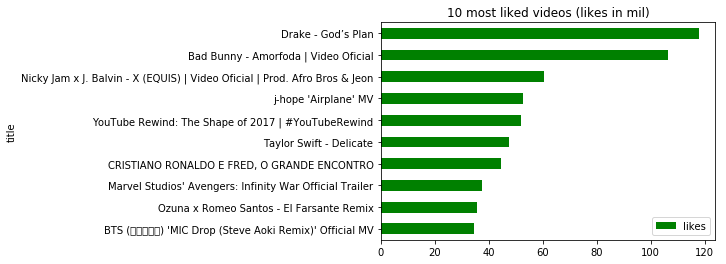

In [37]:

metrics = ['likes','views','comment_count','dislikes']
df_videos_title = df_videos.reset_index().groupby(['country', 'title'])[metrics].sum()
likes = df_videos_title.sort_values('likes',ascending=True)

likes['likes'] = likes.likes / 1000000
likes['comment_count'] = likes.comment_count / 1000000
likes['dislikes'] = likes.dislikes / 1000000
likes['views'] = likes.comment_count / 1000000

likes.reset_index(inplace=True)
likes.tail(10).plot(kind='barh',x='title',y='likes',title= '10 most liked videos (likes in mil)', color='green', sort_columns=True)
plt.figure(figsize = (16,6))

plt.show()

#### Views, Likes, Comment Counts, Dislikes per Country

UK is the country with most likes, the most liked video has reached 120 mil likes, for the US the most liked video only has 25 mil likes. Annother interesting thing to mention is that the tenth video in likes has almost 1/4rth of videos compared to the most liked video for all countries, with the exeption of the US there the diff in likes among the firt 10 videos is not that big. Actually the tenth most liked video for the US has just halpf of the likes compared to the most liked one. 
Another interesting fact is that for every country there is one prominent disliked video and for the rest 9 videos the number of dislikes is close to 0mil.
Views and number of comments follow the same distribution aming the 10 first videos.

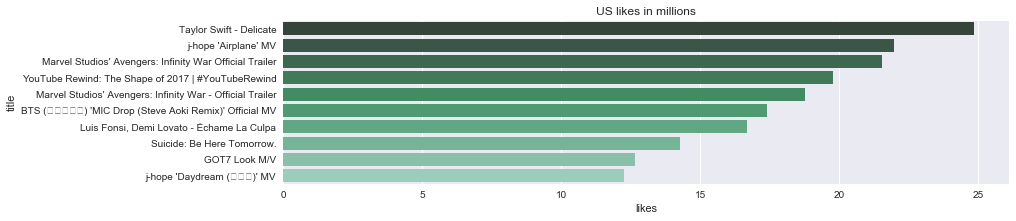

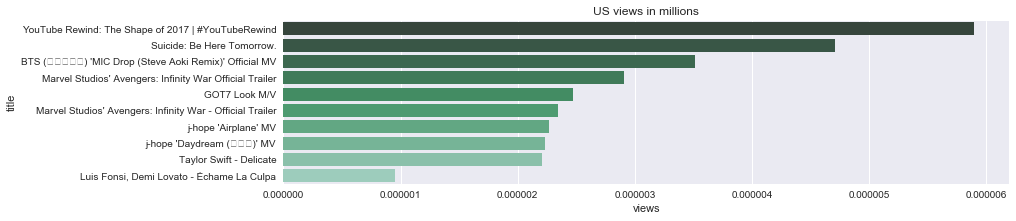

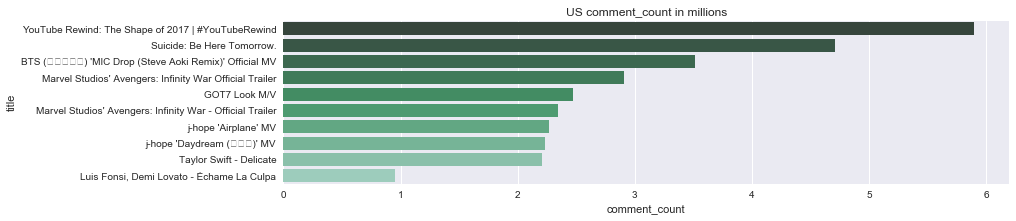

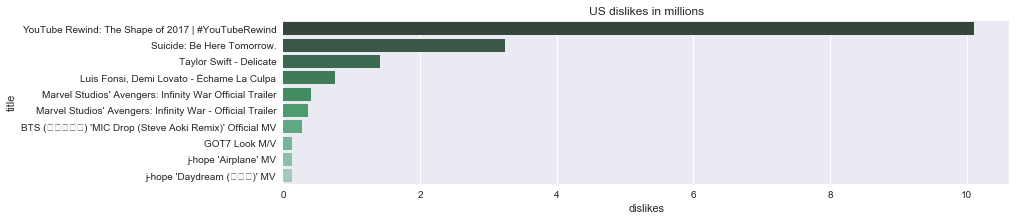

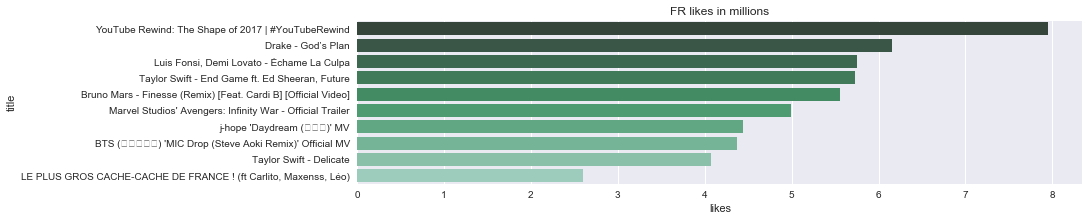

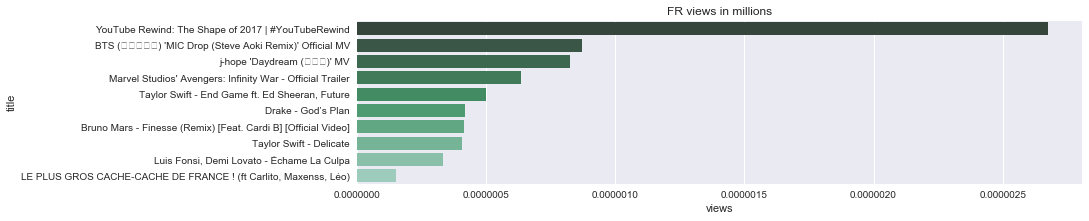

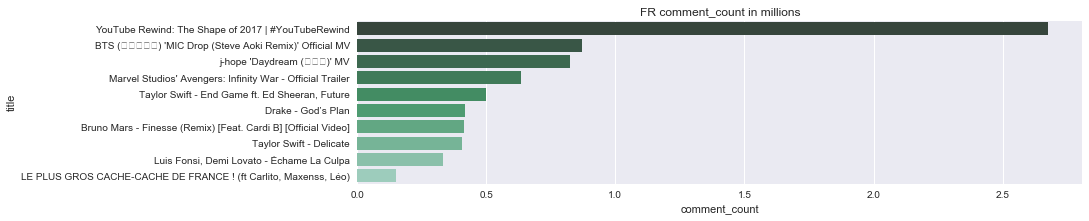

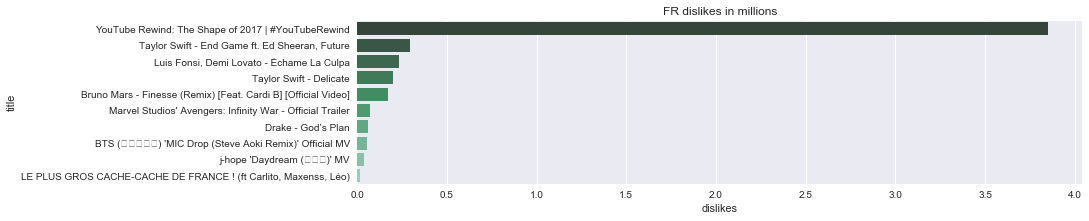

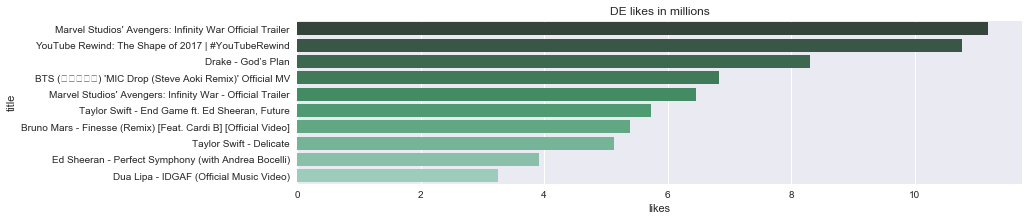

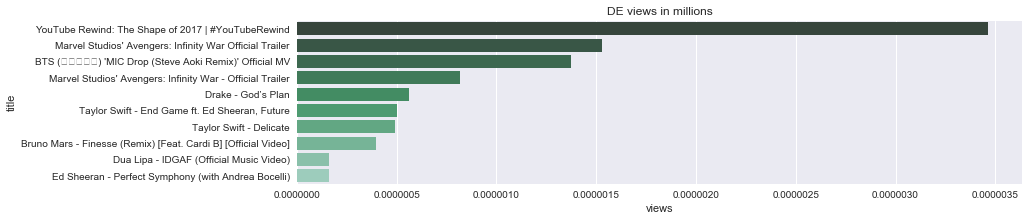

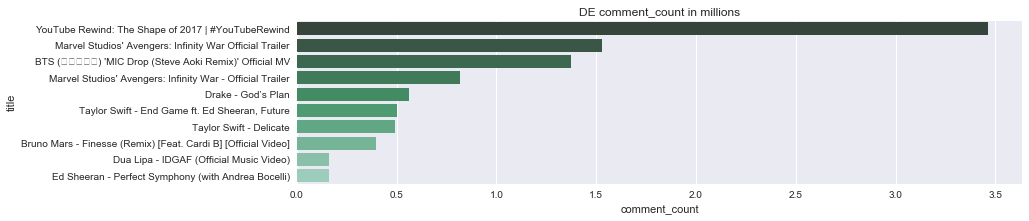

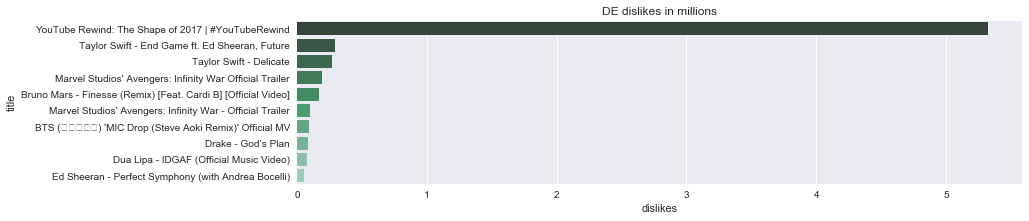

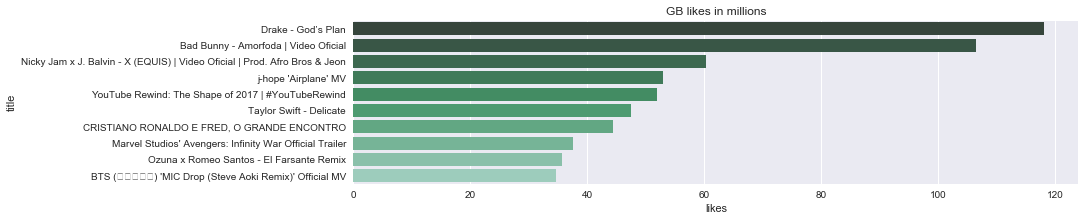

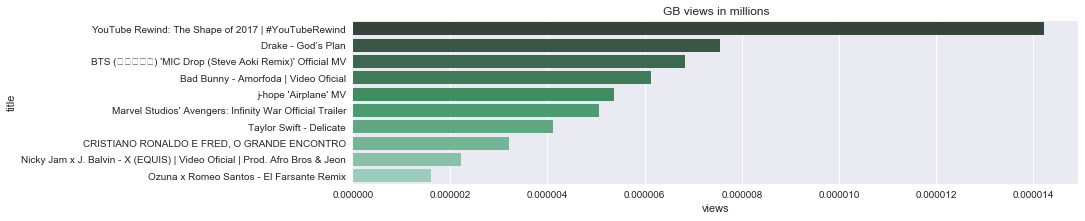

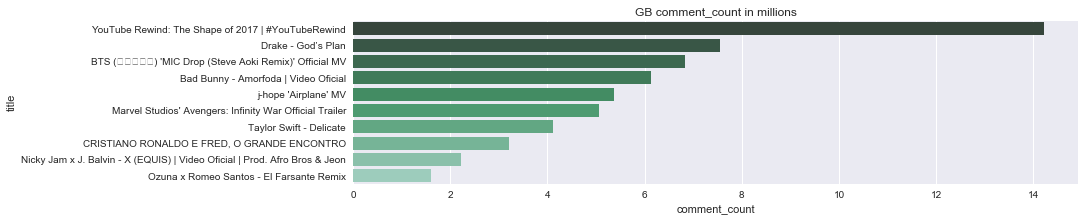

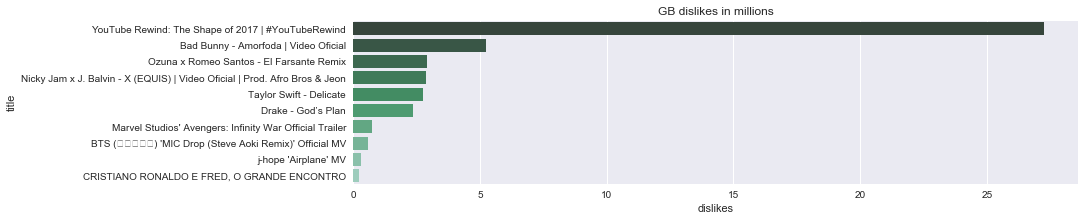

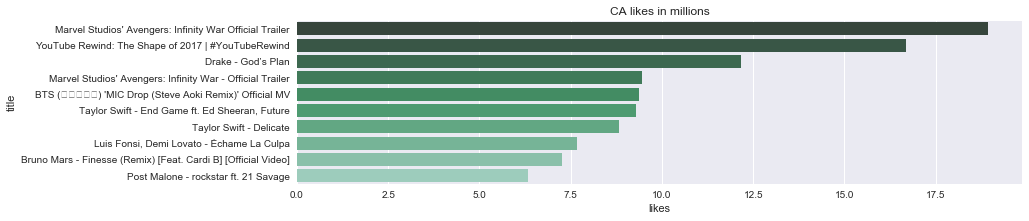

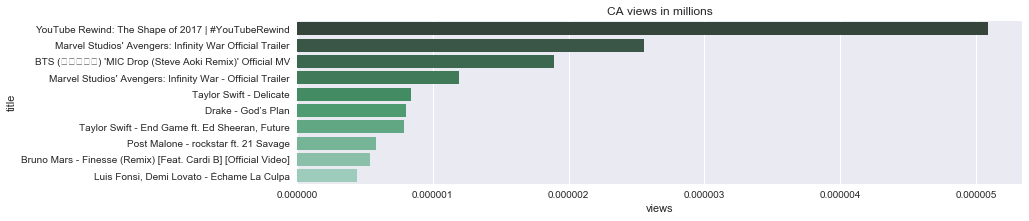

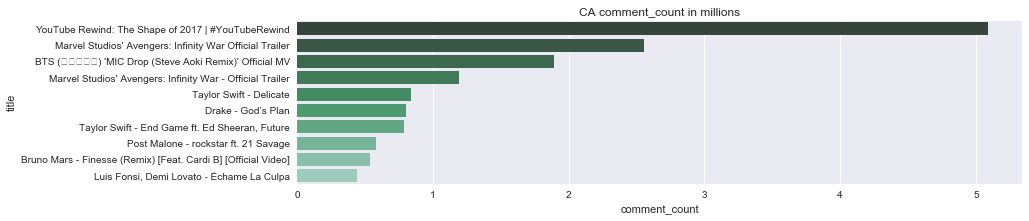

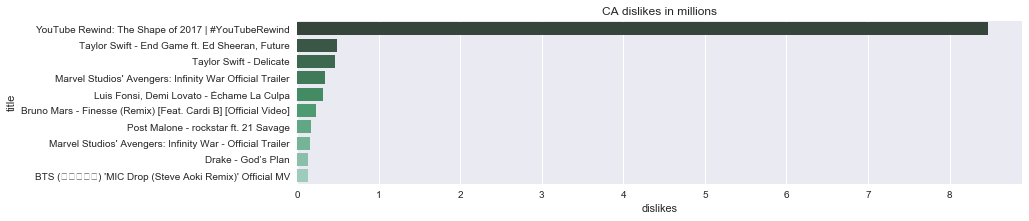

In [38]:
sns.set(rc={'figure.figsize':(13, 3)})
for cntry in likes.country.unique():
    for colm in ['likes', 'views', 'comment_count', 'dislikes']:
        ax = sns.barplot(data=likes.loc[likes.country == cntry, [colm, 'title']].tail(10).\
                     sort_values(colm, ascending=False), y='title',x=colm, 
                        palette="BuGn_d").set_title(cntry + ' ' + colm + ' in millions')
        plt.show()

#### likes per view, dislikes to views

In [39]:
likes['prc_likes'] = likes['likes'] / likes['views']
likes['prc_dislikes'] = likes['dislikes'] / likes['views']

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


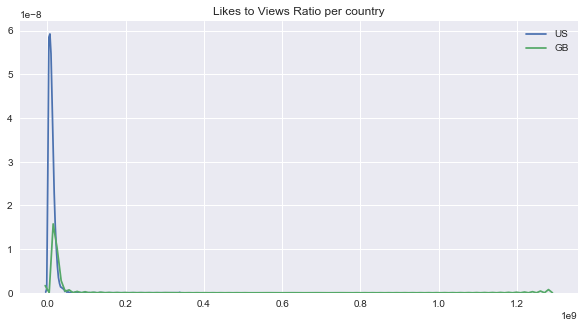

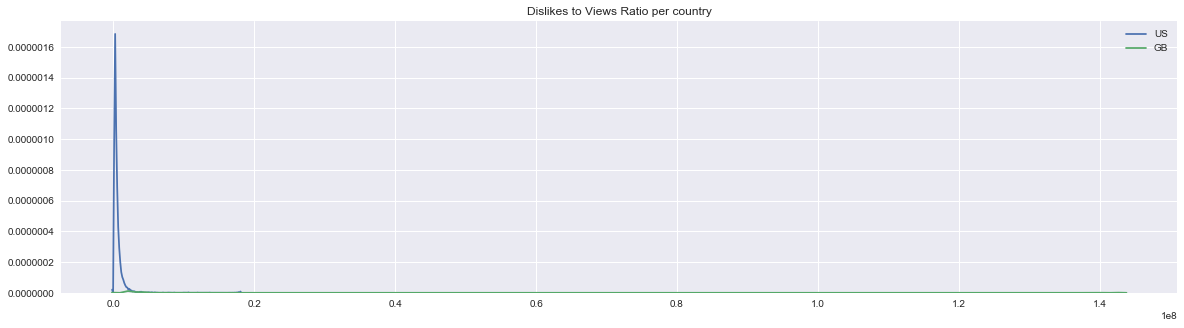

In [40]:
f = plt.figure(figsize=(10,5))

#ax = f.add_subplot(121)
sns.kdeplot(likes.loc[likes.country == 'US', 'prc_likes'], label='US')
sns.kdeplot(likes.loc[likes.country == 'GB', 'prc_likes'], label='GB')
#sns.kdeplot(likes.loc[likes.country == 'FR', 'prc_likes'], label='FR')
#sns.kdeplot(likes.loc[likes.country == 'DE', 'prc_likes'], label='DE')
#sns.kdeplot(likes.loc[likes.country == 'CA', 'prc_likes'], label='CA')
plt.title('Likes to Views Ratio per country')
plt.legend()
plt.show()

f = plt.figure(figsize=(20,5))
#ax2 = f.add_subplot(122)
sns.kdeplot(likes.loc[likes.country == 'US', 'prc_dislikes'], label='US')
sns.kdeplot(likes.loc[likes.country == 'GB', 'prc_dislikes'], label='GB')
#sns.kdeplot(likes.loc[likes.country == 'FR', 'prc_dislikes'], label='FR')
#sns.kdeplot(likes.loc[likes.country == 'DE', 'prc_dislikes'], label='DE')
#sns.kdeplot(likes.loc[likes.country == 'CA', 'prc_dislikes'], label='CA')
plt.legend()
plt.title('Dislikes to Views Ratio per country')
plt.show()

In [41]:
#df_videos.columns

In [42]:
df_videos['prc_likes'] = df_videos['likes'] / df_videos['views']
df_videos['prc_dislikes'] = df_videos['dislikes'] / df_videos['views']
# df_videos.prc_dislikes = df_videos['dislikes'] / df_videos['views']

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


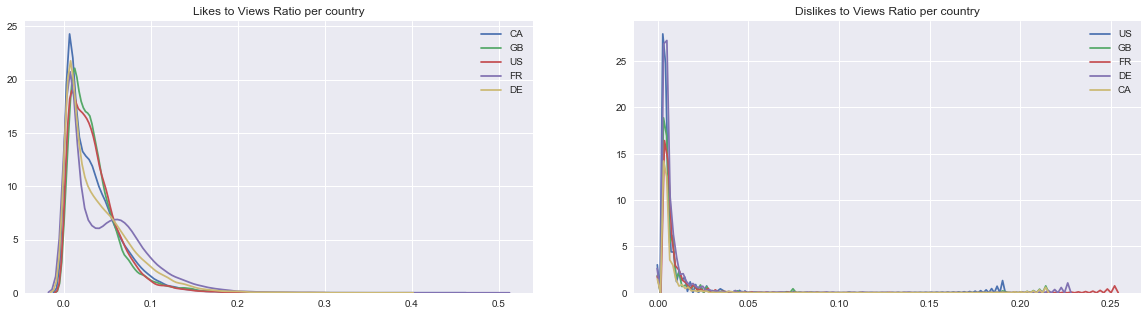

In [43]:
f = plt.figure(figsize=(20,5))

ax = f.add_subplot(121)
sns.kdeplot(df_videos.loc[df_videos.country == 'CA', 'prc_likes'], label='CA')
sns.kdeplot(df_videos.loc[df_videos.country == 'GB', 'prc_likes'], label='GB')
sns.kdeplot(df_videos.loc[df_videos.country == 'US', 'prc_likes'], label='US')
sns.kdeplot(df_videos.loc[df_videos.country == 'FR', 'prc_likes'], label='FR')
sns.kdeplot(df_videos.loc[df_videos.country == 'DE', 'prc_likes'], label='DE')
plt.title('Likes to Views Ratio per country')
plt.legend()


ax2 = f.add_subplot(122)
sns.kdeplot(df_videos.loc[df_videos.country == 'US', 'prc_dislikes'], label='US')
sns.kdeplot(df_videos.loc[df_videos.country == 'GB', 'prc_dislikes'], label='GB')
sns.kdeplot(df_videos.loc[df_videos.country == 'FR', 'prc_dislikes'], label='FR')
sns.kdeplot(df_videos.loc[df_videos.country == 'DE', 'prc_dislikes'], label='DE')
sns.kdeplot(df_videos.loc[df_videos.country == 'CA', 'prc_dislikes'], label='CA')
plt.legend()
plt.title('Dislikes to Views Ratio per country')
plt.show()

In [44]:
#sns.kdeplot(df_videos.loc[df_videos.country == 'US', 'likes'], label='US')
#sns.kdeplot(df_videos.loc[df_videos.country == 'GB', 'likes'], label='GB')
#sns.kdeplot(df_videos.loc[df_videos.country == 'FR', 'likes'], label='FR')
#plt.legend()
#plt.show()

In [45]:
#df_videos.info()

#### Analysis per category, Users like videos from which category the most?

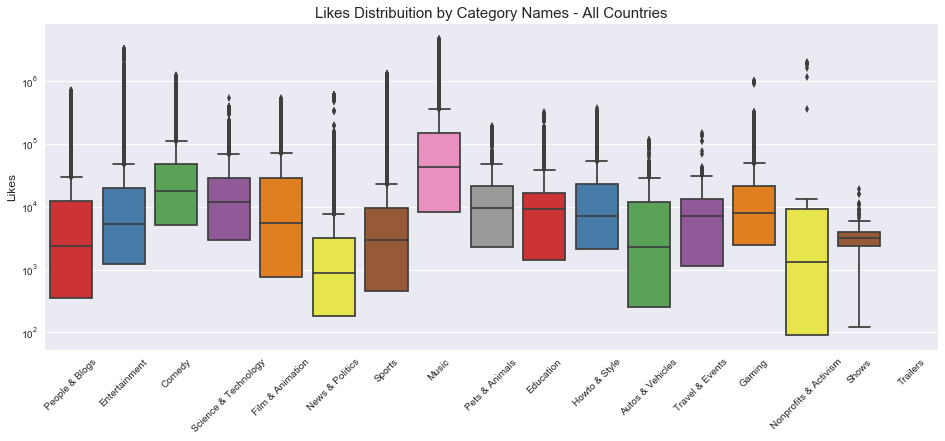

In [46]:
plt.figure(figsize = (16,6))

g = sns.boxplot(x='snippet.title', y='likes', data=df_videos, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Likes Distribuition by Category Names - All Countries", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Likes", fontsize=12)
g.set(yscale="log")
plt.show()

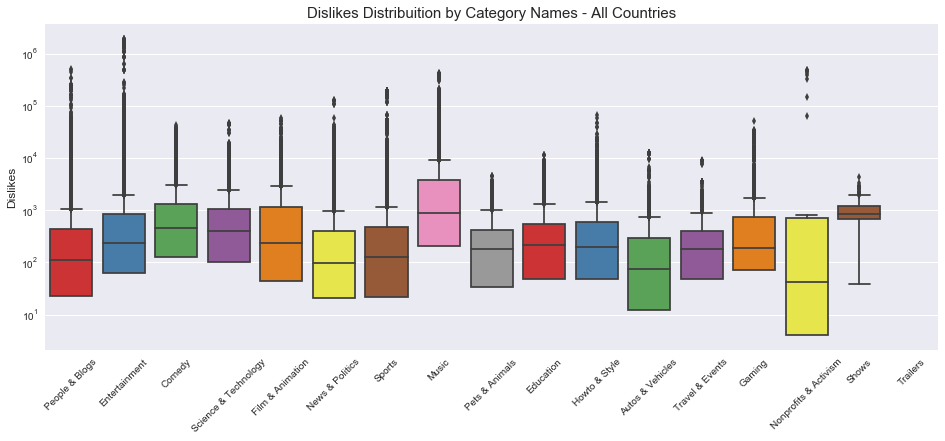

In [47]:
plt.figure(figsize = (16,6))

g = sns.boxplot(x='snippet.title', y='dislikes', data=df_videos, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Dislikes Distribuition by Category Names - All Countries", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Dislikes", fontsize=12)
g.set(yscale="log")
plt.show()

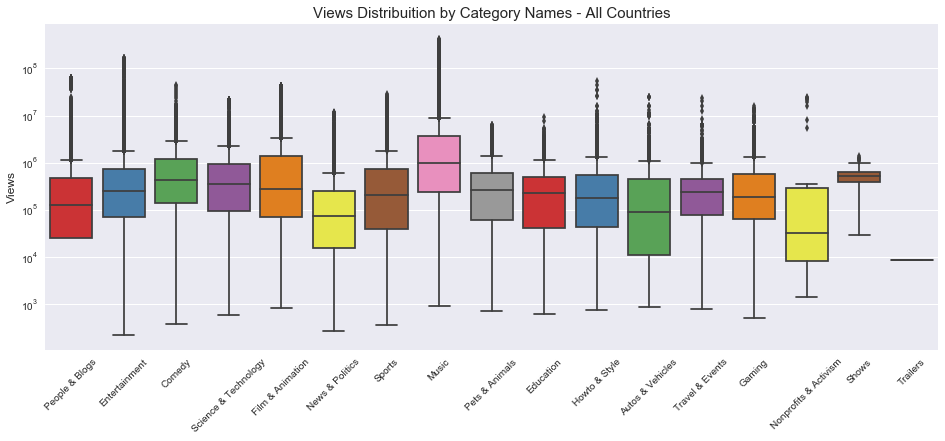

In [48]:
plt.figure(figsize = (16,6))

g = sns.boxplot(x='snippet.title', y='views', data=df_videos, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Views Distribuition by Category Names - All Countries", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Views", fontsize=12)
g.set(yscale="log")
plt.show()

Top category of all countries except GB is Entertainment.
Music's videos ranked insignificantly in Canada, Germany and France compare to US and UK.
Sport's videos are more popular in Canada, Germany and France.
All top 8 categories in United Kingdom entertainment-related, this might not be a good sign.
Show's and Activism's video get the bottom rank in all most countries.

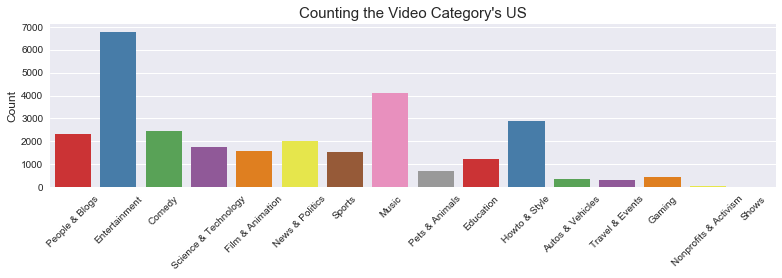

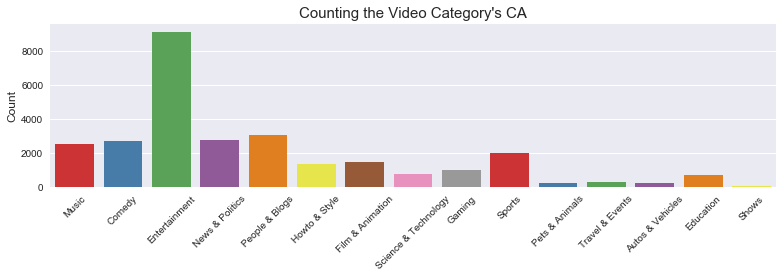

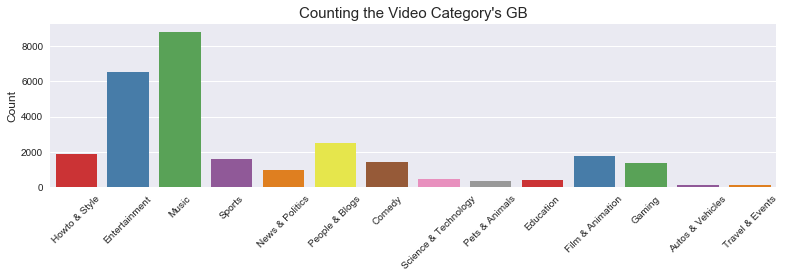

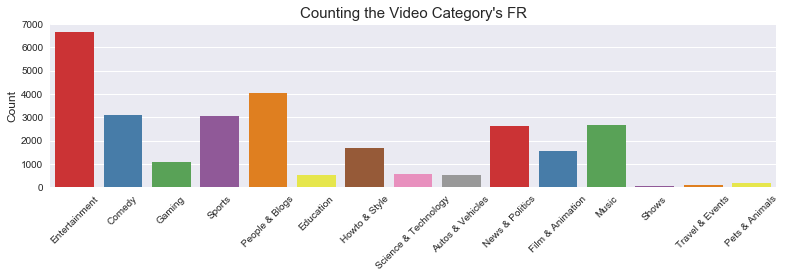

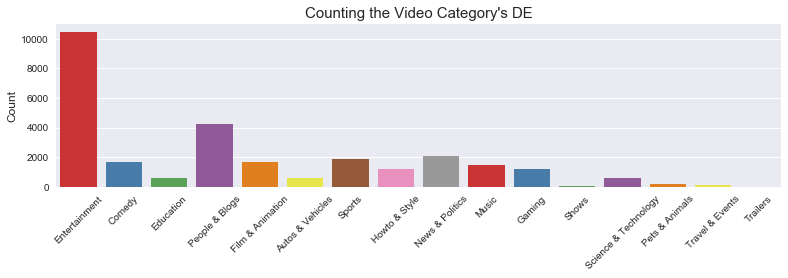

In [49]:
#print(df_videos['snippet.title'].value_counts()[:5])

for i in df_videos.country.unique():
    g = sns.countplot('snippet.title', data=df_videos[df_videos.country==i], palette="Set1")
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g.set_title("Counting the Video Category's "+ i, fontsize=15)
    g.set_xlabel("", fontsize=12)
    g.set_ylabel("Count", fontsize=12)
   # plt.figure(figsize = (0,0))
    plt.show()

### Engagement ratios per category 

Pets & Animals videos have highest likes-dislikes ratio. Not suprisingly, people find difficult to hate pets and animals.
Nonprofit & Activism's videos have lowest likes-dislike ratio and views-comments ratio. People relatively hate these video and comment a lot.
Obviosly, people still prefer implicit feedback than explicit. The ratio of views to comments is so large that only a comment written for hundreds of views.

#### Likes-Dislikes Ratio

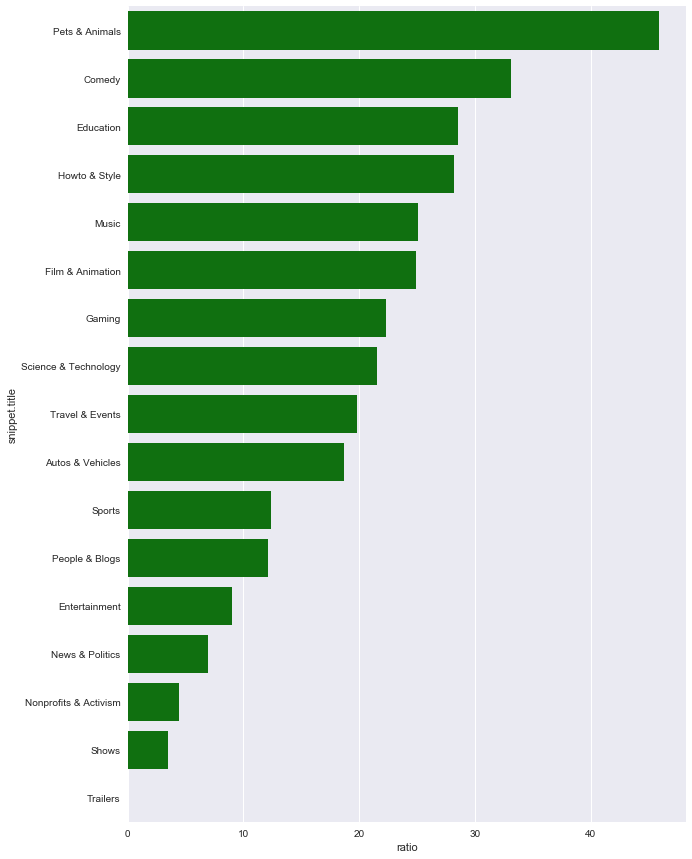

In [50]:
like_dislike_ratio = df_videos.groupby('snippet.title')['likes'].agg('sum') / df_videos.groupby('snippet.title')['dislikes'].agg('sum')
like_dislike_ratio = like_dislike_ratio.sort_values(ascending=False).reset_index()
like_dislike_ratio.columns = ['snippet.title','ratio']
plt.subplots(figsize=(10, 15))
sns.barplot(x='ratio', y='snippet.title', data=like_dislike_ratio, label='Likes-Dislikes Ratio', color="g")

plt.show()

#### Views-Comments Ratio

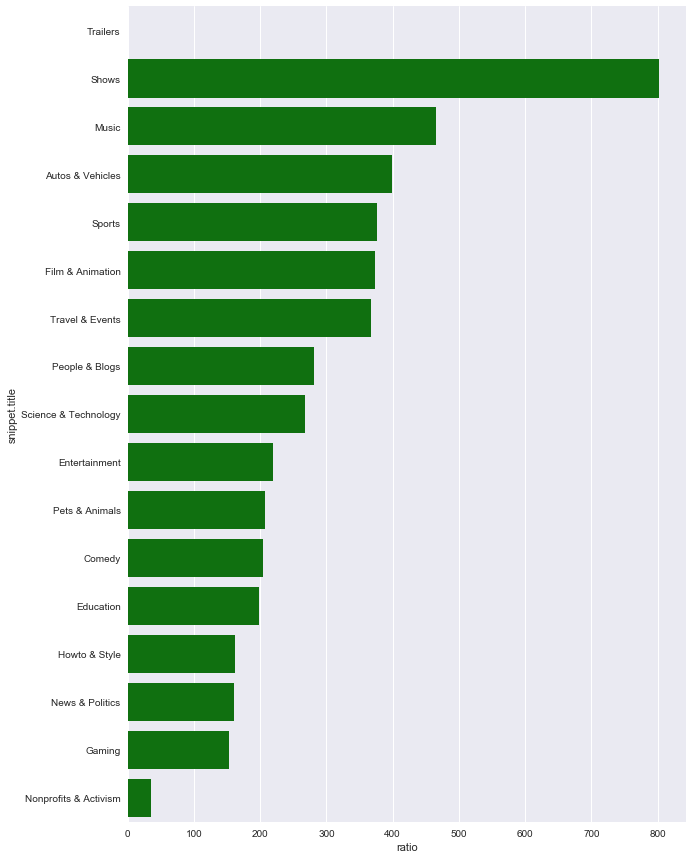

In [51]:
like_dislike_ratio = df_videos.groupby('snippet.title')['views'].agg('sum') / df_videos.groupby('snippet.title')['comment_count'].agg('sum')
like_dislike_ratio = like_dislike_ratio.sort_values(ascending=False).reset_index()
like_dislike_ratio.columns = ['snippet.title','ratio']
plt.subplots(figsize=(10, 15))
sns.barplot(x='ratio', y='snippet.title', data=like_dislike_ratio,label="Likes-Dislikes Ratio", color="g")

plt.show()

#### Dislikes-Views Ratio

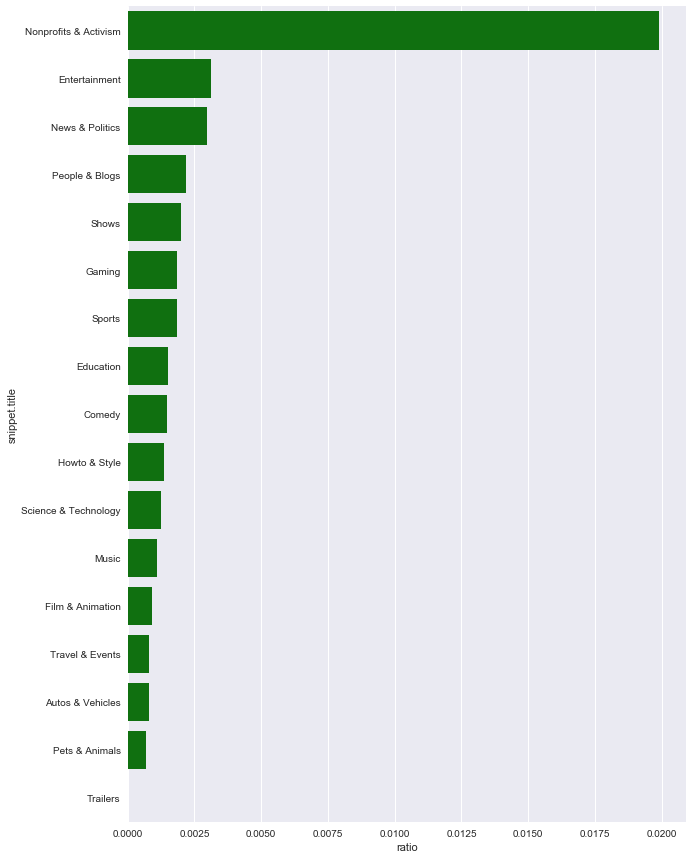

In [52]:
like_dislike_ratio = df_videos.groupby('snippet.title')['dislikes'].agg('sum') / df_videos.groupby('snippet.title')['views'].agg('sum')
like_dislike_ratio = like_dislike_ratio.sort_values(ascending=False).reset_index()
like_dislike_ratio.columns = ['snippet.title','ratio']
plt.subplots(figsize=(10, 15))
sns.barplot(x='ratio', y='snippet.title', data=like_dislike_ratio,label="Likes-Dislikes Ratio", color="g")

plt.show()

#### Likes-Views Ratio

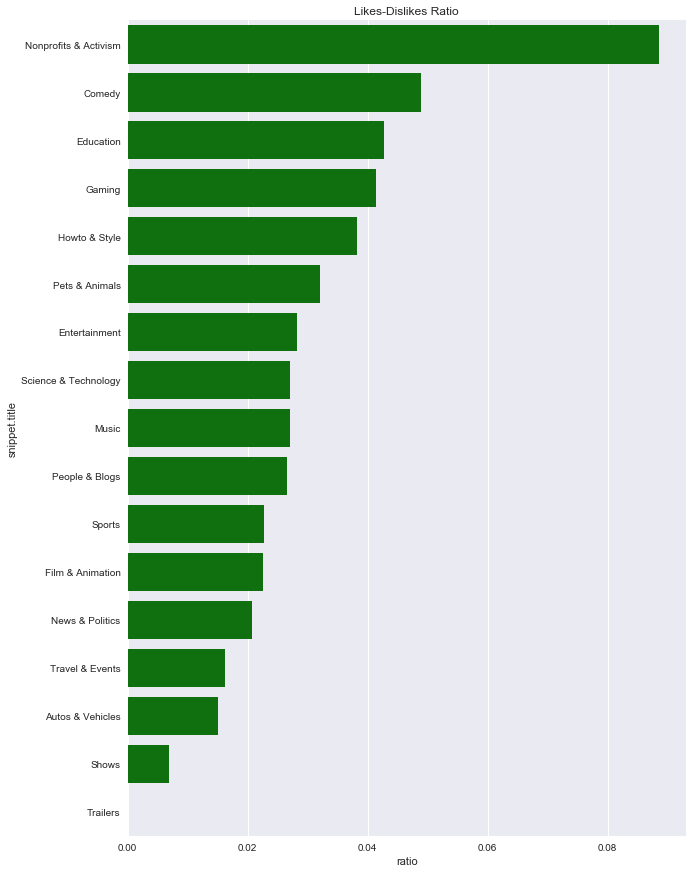

In [124]:
like_dislike_ratio = df_videos.groupby('snippet.title')['likes'].agg('sum') / df_videos.groupby('snippet.title')['views'].agg('sum')
like_dislike_ratio = like_dislike_ratio.sort_values(ascending=False).reset_index()
like_dislike_ratio.columns = ['snippet.title','ratio']
plt.subplots(figsize=(10, 15))
sns.barplot(x='ratio', y='snippet.title', data=like_dislike_ratio,  color="g").set_title('Likes-Dislikes Ratio')

plt.show()

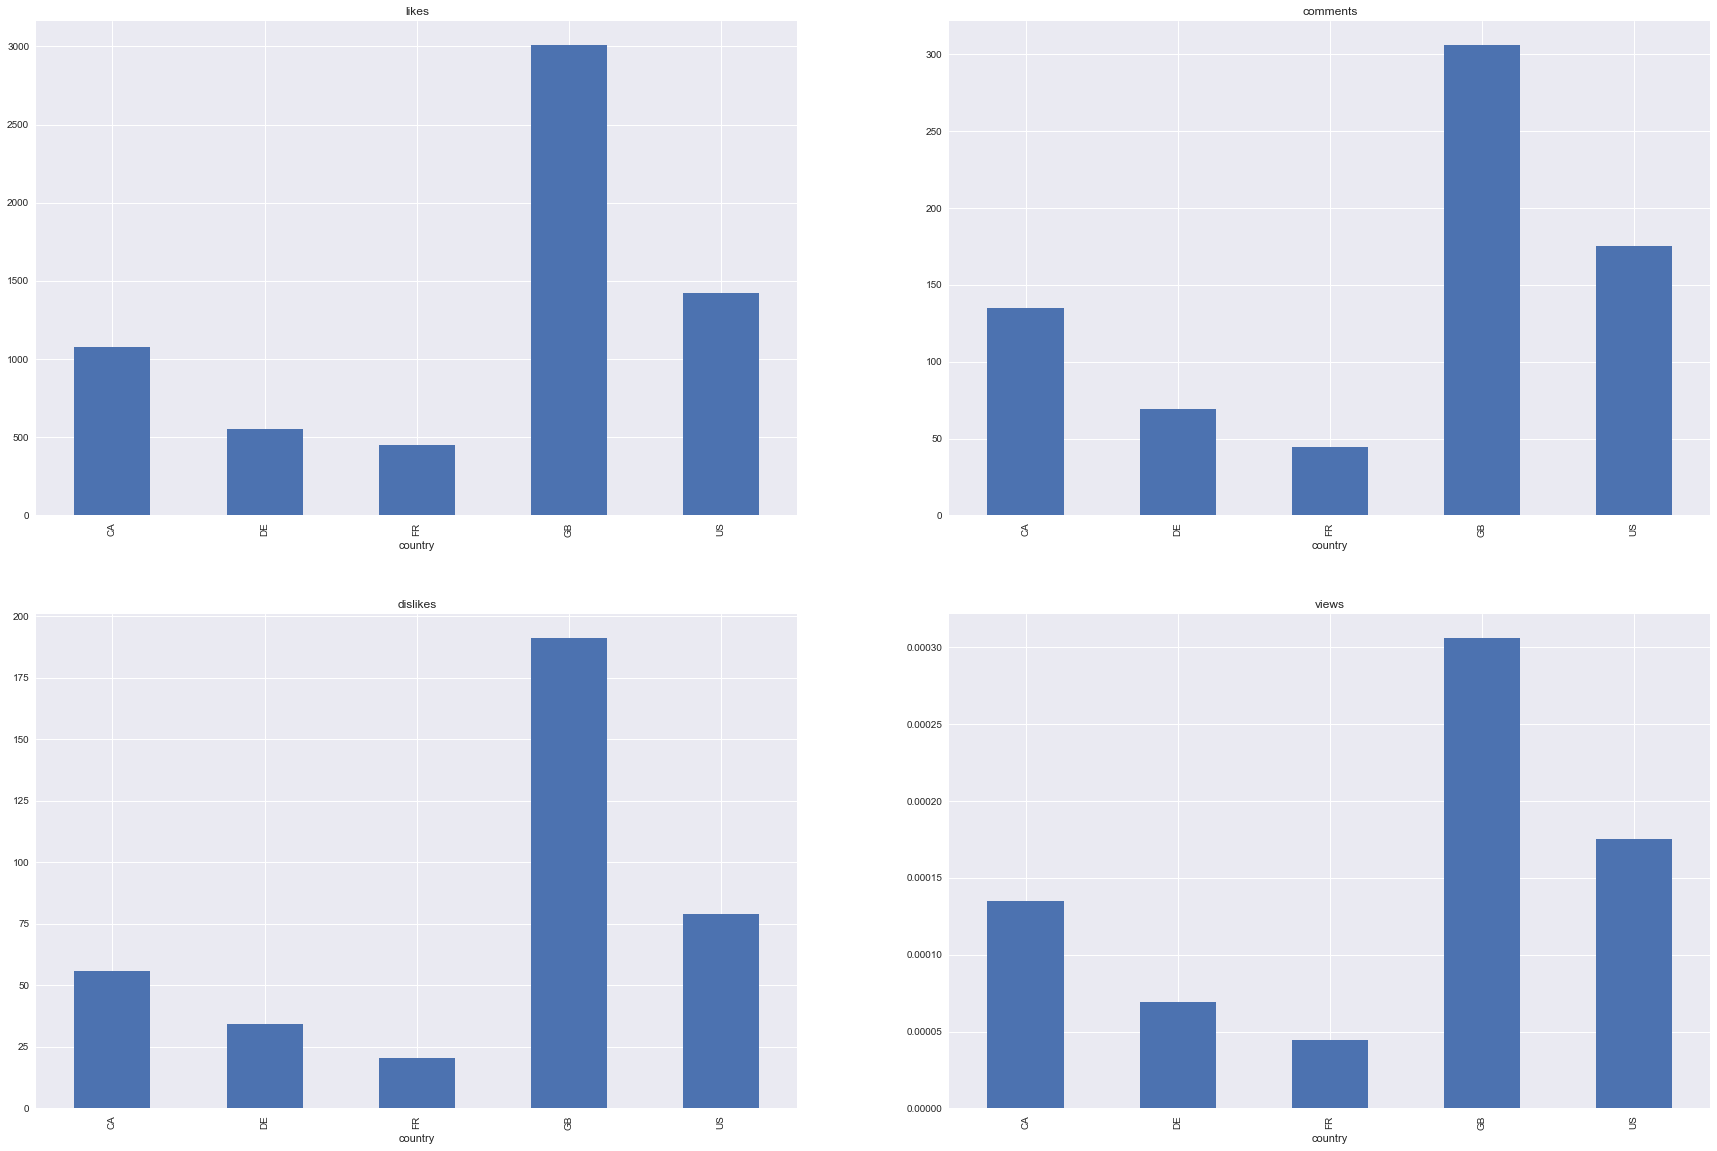

In [54]:
metrics = ['likes','views','comment_count','dislikes']
df_videos_country = df_videos.reset_index().groupby(['country'])[metrics].sum()

fig = plt.figure(figsize=(30, 20))


ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,3)
ax4 = plt.subplot(2,2,4)

df_videos_country ['likes'] = df_videos_country .likes / 1000000
df_videos_country ['comment_count'] = df_videos_country .comment_count / 1000000
df_videos_country ['dislikes'] = df_videos_country .dislikes / 1000000
df_videos_country ['views'] = df_videos_country .comment_count / 1000000

df_videos_country['likes'].plot(kind='bar',title='likes',ax=ax1)
df_videos_country['comment_count'].plot(kind='bar',title='comments',ax=ax2)
df_videos_country['dislikes'].plot(kind='bar',title='dislikes',ax=ax3)
df_videos_country['views'].plot(kind='bar',title='views',ax=ax4)

plt.show()

### How many likes, dislikes, views and comments get different countries?

Obviously, four of the graphs share the similar trend in numbers. One possible reason to this is due to the video's trending duration. Enduring trending videos have the advantages in getting more views, likes, dislikes and comments.

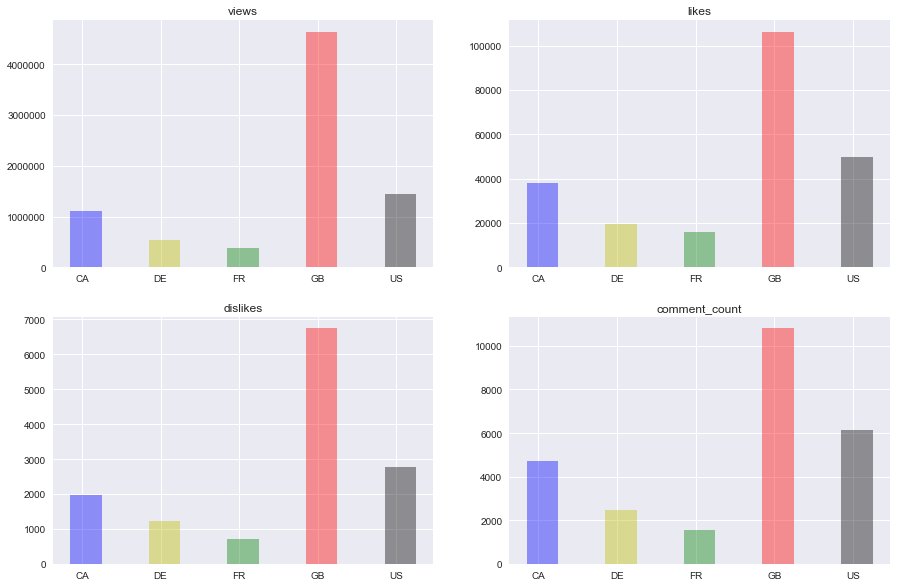

In [55]:

country_list = df_videos.groupby(['country']).count().index

to_int = ['views', 'likes', 'dislikes', 'comment_count']
for column in to_int:
    df_videos[column] = df_videos[column].astype(int)
    
measures = list()
n_groups = len(country_list)
for i, typ in enumerate(to_int):
    measure = list()
    for c in country_list:
        measure.append( df_videos[ df_videos['country']==c][typ].agg('sum')/len( df_videos[ df_videos['country']==c].index.unique()))
    measures.append(measure)

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(ncols=2,nrows=2, figsize=(15,10))

index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.4
error_config = {'ecolor': '0.3'}

for i, axs in enumerate([[ax1, ax2], [ax3, ax4]]):
    for j, ax in enumerate(axs):
        ax.bar(index + (bar_width), measures[(i+j)+i], bar_width*4,
                alpha=opacity, color=['b','y','g','r','k'],
                error_kw=error_config)
        ax.set_title(to_int[(i+j)+i])
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(country_list)
        
plt.show()

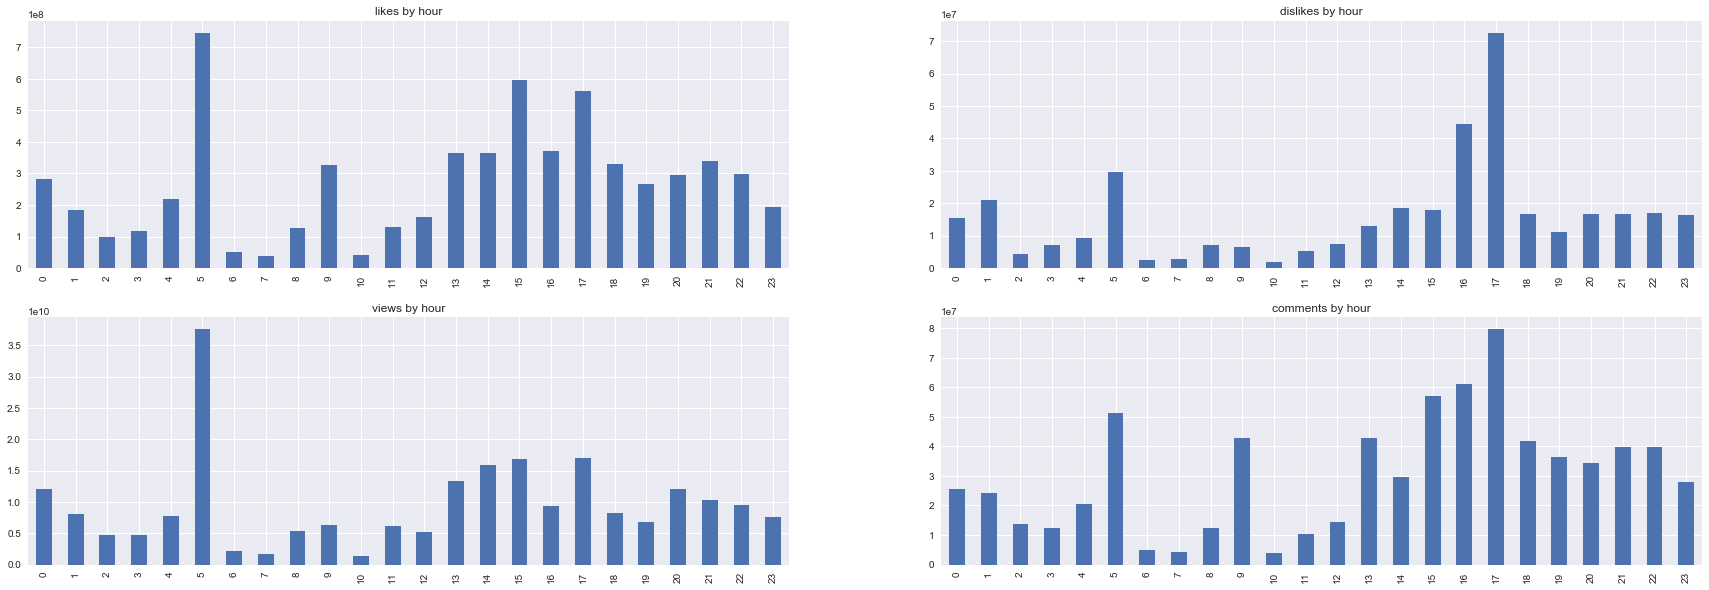

In [56]:
hour_grp = df_videos.groupby('publish_hour')[metrics].sum()
hour_grp.reset_index(inplace=True)

fig = plt.figure(figsize=(30, 10))

ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,3)
ax4 = plt.subplot(2,2,4)


hour_grp['likes'].plot(kind='bar',title='likes by hour',ax=ax1)
hour_grp['dislikes'].plot(kind='bar',title='dislikes by hour',ax=ax2)
hour_grp['views'].plot(kind='bar',title='views by hour',ax=ax3)
hour_grp['comment_count'].plot(kind='bar',title='comments by hour',ax=ax4)

plt.show()

In [57]:
df_videos.head(2)

,Country,Row ID,video_id,trending_date,title,channel_title,category_id,publish_time,tags,likes,...,publish_date,publish_month,publish_day,publish_hour,id,snippet.title,country,views,prc_likes,prc_dislikes
0,US,0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 17:13:01,SHANtell martin,57527,...,2017-11-13,11.0,13.0,17.0,22,People & Blogs,US,748374,0.076869,0.003963
1,US,35,0mlNzVSJrT0,2017-11-14,Me-O Cats Commercial,Nobrand,22,2017-04-21 06:47:32,"cute|""cats""|""thai""|""eggs""",2486,...,2017-04-21,4.0,21.0,6.0,22,People & Blogs,US,98966,0.025120,0.001859


#### Heatmaps of Correlation¶

Question : Does the video trending in one country will trend in other countries too? If yes,how much do they correlate to each other?

Here we got the heatmap of correlation of Youtube Trending Videos between countries. Not suprisingly, the video from United Kingdom, US and Canada is highly correlate to each other compare to Germany and France. This might due to the sharing of common language in these contries. As compare, Germany and France seems like more isolate where they did not follow the trend from english speaking countries (Just my personal opinion by observing the heatmap). This can also explain why United Kingdom has the highest number in long-trend videos, as it is contributes by multiple contries at the same time.

In [58]:
fre_df = pd.DataFrame(df_videos.groupby(['video_id','country']).count()['title'].sort_values(ascending=False)).reset_index()

corr_list = pd.DataFrame(fre_df['video_id'].unique(), columns=['video_id'])
for country_code in fre_df['country'].unique():
    corr_list[country_code] = 0
corr_list['total']=0
corr_list=corr_list.set_index('video_id')
#print new_list
for index , item in corr_list.iterrows():
    #print index
    total = 0
    for i ,row in fre_df[fre_df['video_id'] == index][['country','title']].iterrows():
        total += row['title']
        corr_list.loc[[index],[row['country']]] = row['title']
    corr_list.loc[[index],['total']] = total
corr_list.head()

,GB,US,CA,DE,FR,total
video_id,,,,,,
NooW_RbfdWI,38,10,6,5,3,62
BhIEIO0vaBE,38,10,6,5,4,63
2z3EUY1aXdY,38,4,6,5,5,58
ABLsSWE06q4,37,0,0,0,0,37
4uTNVumfm84,37,10,5,3,2,57


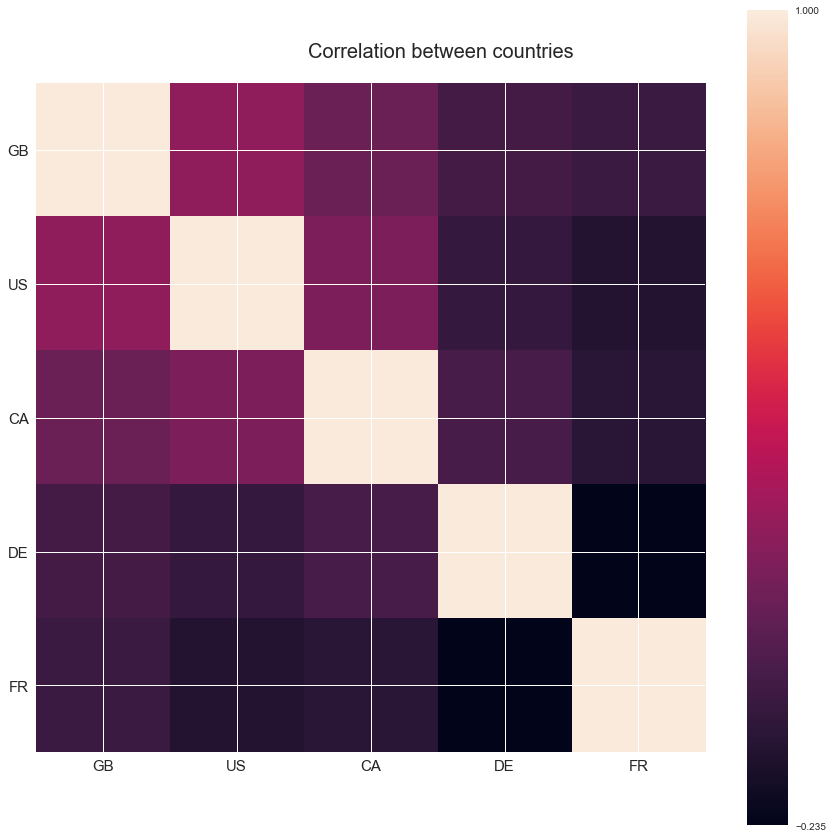

In [59]:
countries = ['GB', 'US', 'CA', 'DE', 'FR'] #looking at correlations between these countries
corr_matrix = corr_list[countries].corr()

fig, ax = plt.subplots(figsize=(15,15))
fig.suptitle('Correlation between countries', fontsize=20).set_y(0.85)
heatmap = ax.imshow(corr_matrix, interpolation='nearest')

# making the colorbar on the side
cbar_min = corr_matrix.min().min()
cbar_max = corr_matrix.max().max()
cbar = fig.colorbar(heatmap, ticks=[cbar_min, cbar_max])

# making the labels
labels = ['']
for column in countries:
    labels.append(column)
#print labels
ax.set_yticklabels(labels, minor=False, fontsize=15)
ax.set_xticklabels(labels, minor=False, fontsize=15)
corr_matrix
plt.show()

In [60]:
df_videos.reset_index()[['country', 'likes']].groupby('country')['likes'].describe() / 1000000

,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
CA,0.028454,0.037925,0.118326,0.0,0.002047,0.008651,0.027956,3.014479
DE,0.028348,0.019445,0.086138,0.0,0.000424,0.002324,0.010672,2.811217
FR,0.028376,0.015773,0.073941,0.0,0.000260,0.001590,0.007438,2.656682
GB,0.028367,0.106145,0.293362,0.0,0.004379,0.018012,0.080541,4.737873
US,0.028550,0.049842,0.151624,0.0,0.003306,0.012273,0.036609,3.093544


In [61]:
df_videos.reset_index()[['country', 'views']].groupby('country')['views'].describe() / 1000000

,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
CA,0.028454,1.100534,3.334410,0.001000,0.136912,0.347801,0.924822,137.843120
DE,0.028348,0.546813,2.265063,0.000518,0.021698,0.100729,0.387915,113.876217
FR,0.028376,0.374071,1.676319,0.000000,0.012939,0.059199,0.229182,100.911567
GB,0.028367,4.633414,17.359009,0.000851,0.183628,0.691551,2.515851,424.538912
US,0.028550,1.444015,4.384003,0.000549,0.154735,0.440671,1.235440,149.376127


In [62]:
df_videos.reset_index()[['country', 'dislikes']].groupby('country')['dislikes'].describe() / 1000000

,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
CA,0.028454,0.001964,0.021562,0.0,0.000093,0.000284,0.000929,1.602383
DE,0.028348,0.001212,0.015807,0.0,0.000023,0.000115,0.000469,1.470386
FR,0.028376,0.000721,0.012434,0.0,0.000014,0.000068,0.000292,1.353661
GB,0.028367,0.006741,0.056883,0.0,0.000150,0.000583,0.002482,1.944971
US,0.028550,0.002771,0.032345,0.0,0.000134,0.000426,0.001344,1.674420


In [ ]:
df_videos.reset_index()[['country', 'comment_count']].groupby('country')['comment_count'].describe() / 1000000

In [ ]:
#df_videos.views = df_videos['views'].astype(int)
#a = [type(i) for i in df_videos['views'] ]
#set(a)
#b = [isinstance(i, str) for i in df_videos['views'] ]
#df_videos['view_is_str'] = df_videos['views'].apply(lambda x: isinstance(x, str))
#int(df_videos.loc[df_videos.view_is_str, 'views'].iloc[0])
#df_videos.views = df_videos.views.apply(lambda x: int(x))

In [63]:
plt.figure(figsize = (15,15))

stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='black',
                          stopwords=stopwords,
                          max_words=150,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df_videos['title']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.title("WORD CLOUD - DESCRIPTION")
plt.axis('off')
plt.show()

NameError: name 'STOPWORDS' is not defined

In [ ]:
def wcloud(data,bgcolor):
    plt.figure(figsize = (20,15))
    cloud = WordCloud(background_color = bgcolor, max_words = 100,  max_font_size = 50)
    cloud.generate(' '.join(data))
    plt.imshow(cloud)
    plt.axis('off')

In [ ]:
df_videos.head(1)

In [ ]:
tags_word = df_videos[df_videos['snippet.title']=='News & Politics']['tags'].str.lower().str.cat(sep=' ')

tags_word = re.sub('[^A-Za-z]+', ' ', tags_word)
word_tokens = word_tokenize(tags_word)
filtered_sentence = [w for w in word_tokens if not w in en_stopwords]
without_single_chr = [word for word in filtered_sentence if len(word) > 2]
cleaned_data_title = [word for word in without_single_chr if not word.isdigit()]

wcloud(cleaned_data_title,'white')

In [ ]:
df_videos.info()

In [ ]:
df_videos_title.head()

In [ ]:
#df_videos_title.reset_index()['country'] == 'FR'

In [ ]:
#df_videos_title['likes']>0

In [ ]:
# sns.kdeplot(df_videos.loc[list((df_videos_title.reset_index()['country'] == 'FR') & (df_videos_title.reset_index()['likes']>0)), 'likes'], 
#             label='FR')
sns.kdeplot(df_videos.loc[list(df_videos_title.reset_index()['country'] == 'GB'), 'likes'], label='GB')
# sns.kdeplot(df_videos_title.loc[list(df_videos_title.reset_index()['country'] == 'US'), 'likes'], label='US')
plt.legend()
plt.show()

In [ ]:
df_videos_title.shape

In [ ]:
likes.head()

#### Most liked videos of all countries

#### Most viewd videos of all countries

#### 10 most liked, disliked, viewed videos per country

In [ ]:
#likes.groupby('country').tail(10)

In [ ]:
#g = sns.FacetGrid(melted, col="variable")
#g.map(sns.barplot,'interval','value')

In [ ]:
#likes.loc[likes.country == cntry, ['likes', 'title']].tail(10)

In [ ]:
#grid = sns.FacetGrid(likes.groupby('country').tail(10)[['title', 'likes', 'country']], col='country')
#g = grid.map(sns.barplot,  'likes', 'title')
# grid.axes[0][0].legend()
# bp.set_titles("{col_name}")
# bp.set_ylabels("Time (s)")
# bp.set_xlabels("Number")


In [ ]:
# fig, ax = plt.subplots(nrows=2, ncols=3)
#for cntry in likes.country.unique():
#plt.subplots(nrows=2, ncols=3)
#likes[likes.country == cntry][['likes', 'title']].tail(10).plot(kind='barh',x='title',y='likes', title= '10 most liked videos')
#plt.show()

In [ ]:
#likes.tail(10)

### Trend Videos

In [127]:
df_videos_trend = pd.DataFrame(df_videos.reset_index().groupby(['country', 'video_id'])['title'].count())
df_videos_trend.reset_index(inplace=True)
#df_videos_trend.info()

In [128]:
df_videos_trend.head(10)

,country,video_id,title
0,CA,--wOJ2VyKDI,1
1,CA,-0DjA_r32uQ,1
2,CA,-0F7AFzWXik,1
3,CA,-0NhqVYR4UY,1
4,CA,-0QvjiG4sYM,2
5,CA,-0XP8UXesHg,1
6,CA,-0qe75Q5vOg,1
7,CA,-10X8LZxvOE,1
8,CA,-195_1aDUyc,2
9,CA,-2ZDiW0dgIw,1


How long usually a video can trend in different countries?
The greater the number of apperances indicate the long-last the video trend is.

In [129]:
df_videos_trend.reset_index(inplace=True)

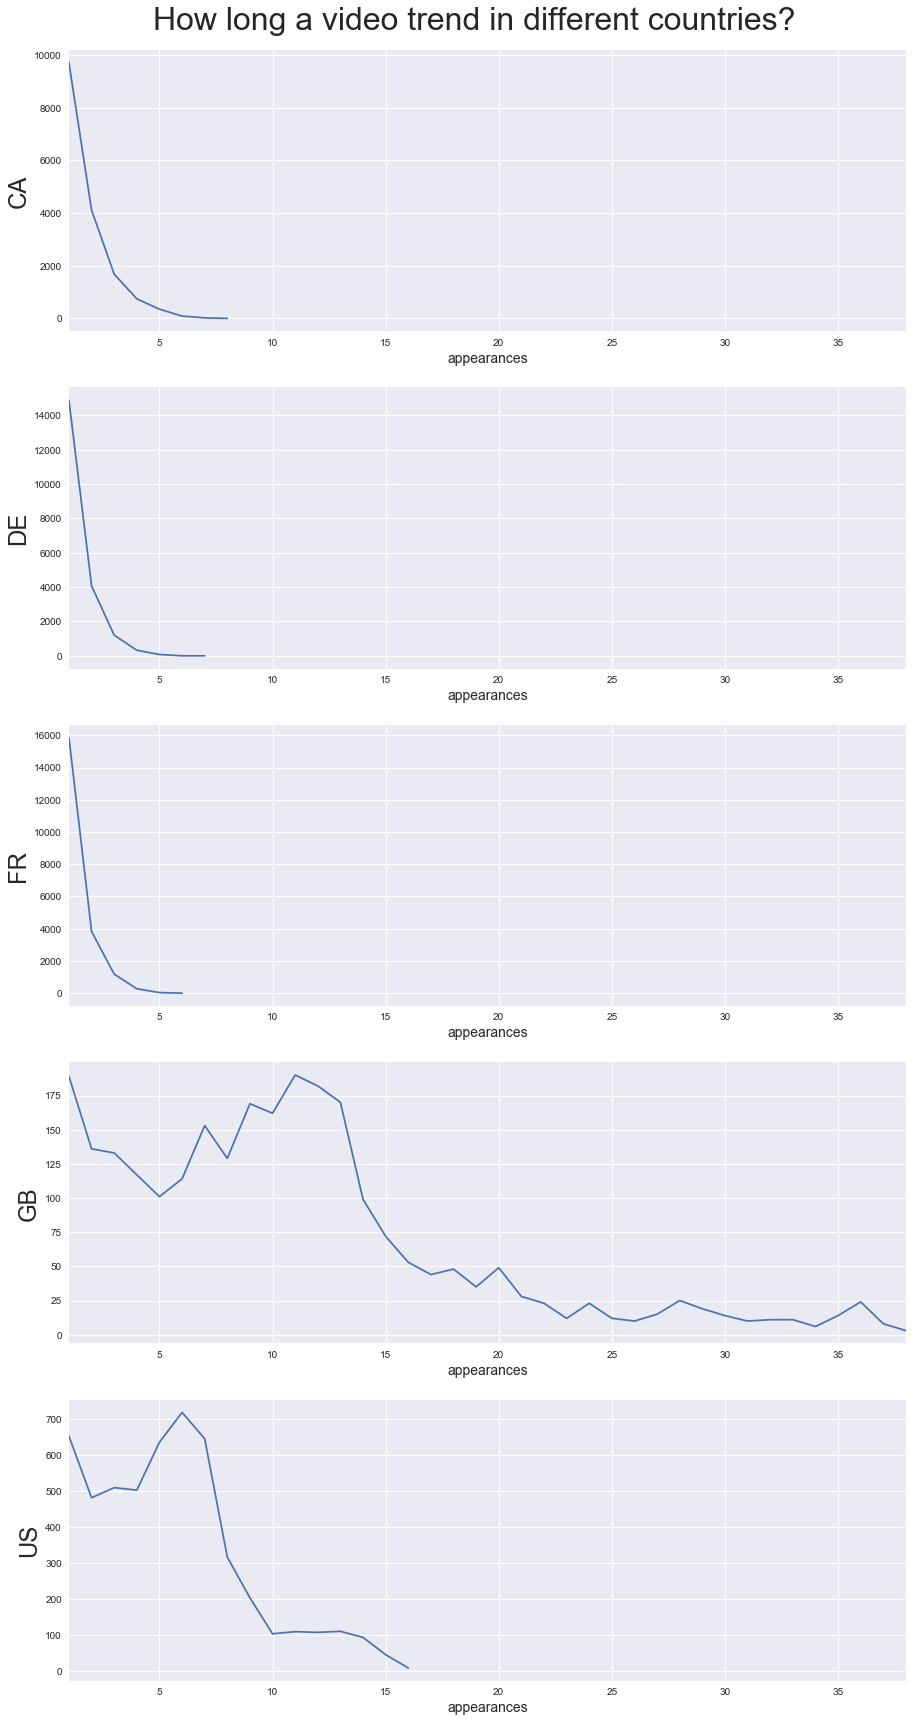

In [130]:
video_list,max_list = list(),list()
country_list = df_videos.groupby(['country']).count().index

for c in country_list:
    video_list.append(df_videos_trend[df_videos_trend['country']==c]['title'].value_counts().sort_index())
    max_list.append(max(df_videos_trend[df_videos_trend['country']==c]['title'].value_counts().sort_index().index))

fig, [ax0, ax1, ax2, ax3, ax4] = plt.subplots(nrows=5,figsize=(15, 30))
st = fig.suptitle("How long a video trend in different countries?", fontsize=32)
st.set_y(0.9)
for i, pt in enumerate([ax0, ax1, ax2, ax3, ax4]):
    pt.plot(video_list[i].index, video_list[i])
    pt.spines['right'].set_visible(False)
    pt.spines['top'].set_visible(False)
    pt.set_xlabel("appearances",fontsize=14)
    pt.set_ylabel(country_list[i],fontsize=24)
    pt.axes.set_xlim(1, max(max_list))

# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(wspace=0)

plt.show()


In [ ]:
#print(df_videos['snippet.title'].value_counts()[:5])

## How many likes, dislikes, views and comments get by different countries?

In [65]:
len(df_videos['publish_date'])

142095

In [67]:
df_videos.head()

,Country,Row ID,video_id,trending_date,title,channel_title,category_id,publish_time,tags,likes,...,publish_date,publish_month,publish_day,publish_hour,id,snippet.title,country,views,prc_likes,prc_dislikes
0,US,0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 17:13:01,SHANtell martin,57527,...,2017-11-13,11.0,13.0,17.0,22,People & Blogs,US,748374,0.076869,0.003963
1,US,35,0mlNzVSJrT0,2017-11-14,Me-O Cats Commercial,Nobrand,22,2017-04-21 06:47:32,"cute|""cats""|""thai""|""eggs""",2486,...,2017-04-21,4.0,21.0,6.0,22,People & Blogs,US,98966,0.025120,0.001859
2,US,44,STI2fI7sKMo,2017-11-14,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH - GOOGLE US | Shawn and Andrew",Shawn Johnson East,22,2017-11-11 15:00:03,"shawn johnson|""andrew east""|""shawn east""|""shawn and andrew""|""olympian""|""nfl player""|""athletes""|""vlog""|""couples""|""google irl""|""google feud""|""google markiplier""|""google myself""|""challenge""|""reactions""|""reacts""|""internet""|""memes""|""funny""|""birthday""|""cringe""|""laughing""|""daily""|""vlogger""|""stupid""|""cute""|""boy""|""diy""|""google""|""myself""|""googled""|""googling""|""liza""|""lizakoshy""|""wednesdays""|""liza koshy""|""googling myself""|""liza koshy net worth""|""liza koshy google""|""liza facts""|""liza panties""|""net worth""|""youtuber net worth""|""youtuber facts""",4451,...,2017-11-11,11.0,11.0,15.0,22,People & Blogs,US,321053,0.013864,0.005519
3,US,54,KODzih-pYlU,2017-11-14,BLIND(folded) CAKE DECORATING CONTEST (with Molly Burke) // Grace Helbig,Grace Helbig,22,2017-11-11 18:08:04,"itsgrace|""funny""|""comedy""|""vlog""|""grace""|""helbig""|""gracehelbig""|""dailygrace""|""daily""|""tutorial""|""diy""|""lifestyle""",7250,...,2017-11-11,11.0,11.0,18.0,22,People & Blogs,US,197062,0.036790,0.001101
4,US,66,8mhTWqWlQzU,2017-11-14,Wearing Online Dollar Store Makeup For A Week,Safiya Nygaard,22,2017-11-11 01:19:33,"wearing online dollar store makeup for a week|""online dollar store makeup""|""dollar store makeup""|""daiso""|""shopmissa makeup""|""shopmissa haul""|""dollar store makeup haul""|""dollar store""|""shopmissa""|""foundation""|""concealer""|""eye primer""|""eyebrow pencil""|""eyeliner""|""bronzer""|""contour""|""face powder""|""lipstick""|""$1""|""$1 makeup""|""safiya makeup""|""safiya dollar store""|""safiya nygaard""|""safiya""|""safiya and tyler""",115426,...,2017-11-11,11.0,11.0,1.0,22,People & Blogs,US,2744430,0.042058,0.000404


In [120]:
tmp = df_videos.set_index('publish_date')
tmp.index = pd.to_datetime(tmp.index)
tmp = tmp[tmp.index >='2017-11-01'].groupby([pd.TimeGrouper('W'), 'Country'])['likes'].sum()

In [ ]:
tmp.plot()

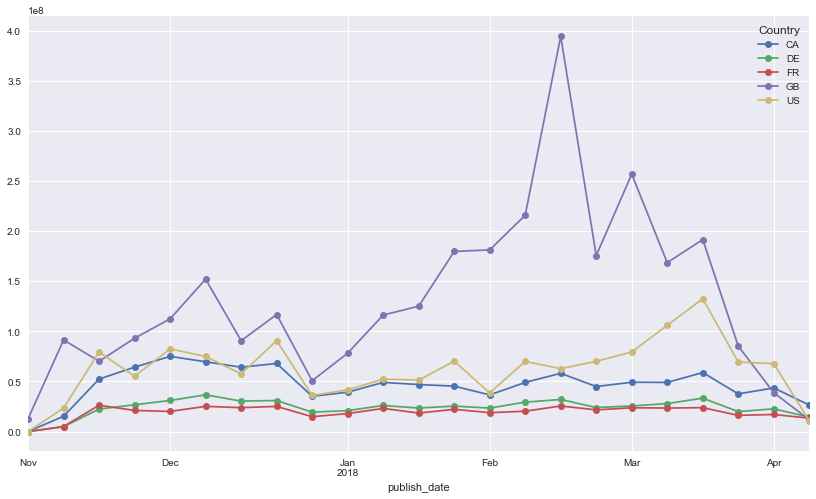

In [125]:
tmp.unstack().plot(figsize=(14, 8), marker='o')
plt.show()

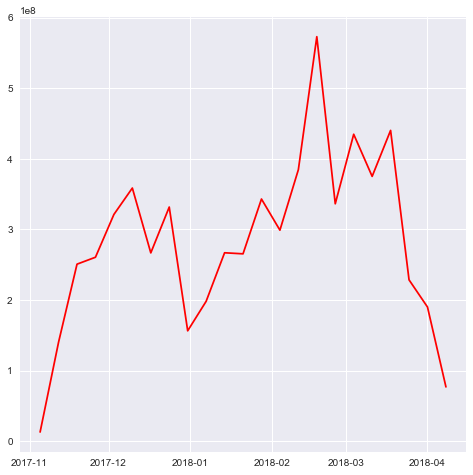

In [105]:
metrics = ['likes']
df_videos_country_time = df_videos.reset_index().groupby(['publish_date'])[metrics].sum()



plt.figure(figsize=(8,8))
plt.plot(tmp[tmp.index >='2017-11-01'].resample('W').sum().index,
         tmp[tmp.index >='2017-11-01'].resample('W').sum(),color="red",label="likes")

plt.show()

cat_df_gb = videos_all[videos_all['Country']=='GB']['category'].value_counts().reset_index()

video_level['views_min_dt'] = video_level.views_min_dt.dt.to_period('Q')
tmp = video_level.groupby(['category','views_min_dt']).views_ratio.median()
_ = tmp.unstack().plot(kind='bar')

hour_grp = df_videos.groupby('publish_hour')[metrics].sum()
hour_grp.reset_index(inplace=True)

Analysis : Users like videos from which CATEGORY the most?

In [149]:
df_videos


,level_0,index,Country,Row ID,video_id,trend_duration,publish_to_trend,publish_to_trend_last,trending_date,title,...,publish_date,publish_month,publish_day,publish_hour,id,snippet.title,country,views,prc_likes,prc_dislikes
0,0,0,US,0,2kyS6SvSYSE,NaN,NaN,1,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,...,2017-11-13,11.0,13.0,17.0,22,People & Blogs,US,748374,0.076869,0.003963
1,1,1,US,35,0mlNzVSJrT0,NaN,NaN,207,2017-11-14,Me-O Cats Commercial,...,2017-04-21,4.0,21.0,6.0,22,People & Blogs,US,98966,0.025120,0.001859
2,2,2,US,44,STI2fI7sKMo,NaN,NaN,3,2017-11-14,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH - GOOGLE US | Shawn and Andrew",...,2017-11-11,11.0,11.0,15.0,22,People & Blogs,US,321053,0.013864,0.005519
3,3,3,US,54,KODzih-pYlU,NaN,NaN,3,2017-11-14,BLIND(folded) CAKE DECORATING CONTEST (with Molly Burke) // Grace Helbig,...,2017-11-11,11.0,11.0,18.0,22,People & Blogs,US,197062,0.036790,0.001101
4,4,4,US,66,8mhTWqWlQzU,NaN,NaN,3,2017-11-14,Wearing Online Dollar Store Makeup For A Week,...,2017-11-11,11.0,11.0,1.0,22,People & Blogs,US,2744430,0.042058,0.000404
5,5,5,US,85,pa_oUisZZy0,NaN,NaN,3,2017-11-14,Mark Ruffalo Reads Hilarious Thirst Tweets,...,2017-11-11,11.0,11.0,0.0,22,People & Blogs,US,177707,0.035288,0.000495
6,6,6,US,100,fCTKDn3Q8xQ,NaN,NaN,5,2017-11-14,Idiot's Guide to Japanese Squat Toilets,...,2017-11-09,11.0,9.0,11.0,22,People & Blogs,US,1098897,0.039926,0.001207
7,7,7,US,119,_dhneCO4YEE,NaN,NaN,5,2017-11-14,"Russian Bots and Trolls | November 8, 2017 Act 2 | Full Frontal on TBS",...,2017-11-09,11.0,9.0,7.0,22,People & Blogs,US,362009,0.015207,0.006508
8,8,8,US,120,EYkEshCOhEU,NaN,NaN,4,2017-11-14,The Ultimate Red Lip Look | Nicole Guerriero,...,2017-11-10,11.0,10.0,0.0,22,People & Blogs,US,294387,0.051792,0.001308
9,9,9,US,123,Eg_kW5fw6qU,NaN,NaN,5,2017-11-14,Could Anastasia Become A Disney Princess?,...,2017-11-09,11.0,9.0,23.0,22,People & Blogs,US,188003,0.048356,0.000718
